<br>
<font size="9"><center>Nebula Graph</center></font>
<br>
<center><h4>Tim Alfa - Mihael Petrinjak, Zvonimir Vlaić</h4></center>

# Sadržaj


[Sadržaj](#Sadržaj)

[Uvod](#Uvod)

[Arhitektura Nebula Graph baze](#Arhitektura-Nebula-Graph-baze)

[Primjene](#Primjene)

[nGQL](#nGQL)

[Migracija baze "nbp_trgovina"](#Migracija-baze-"nbp_trgovina"f)

[Aplikacija](#Aplikacija)

[Zaključak](#Zaključak)

[Literatura](#Literatura)



# Uvod

U ovoj jupyter bilježnici je opisana ***Nebula Graph***, open-source grafovska baza podataka koja zbog specifičnog načina spremanja podataka omogućuje veliku brzinu upravljanja podatcima. 

Na početku je opisana arhitektura sustava na kojoj se Nebula Graph temelji i pojedini servisi od kojih se Nebula Graph sastoji. Potom su navedene najčešće primjene korištenja Nebula Graph baze. Slijedi dio koji opisuje nGQL, deklarativni jezik za upite u grafovskoj bazi podataka napravljen upravo za Nebula Graph baze. 

Nakon toga opisujemo kako smo unijeli već postojeću bazu podataka u Nebula Graph bazu i na kraju jupyter bilježnice je demo aplikacija koja demonstrira povezivanje aplikacijskog i baznog sustava kao i izvršavanje osnovnih upita preko aplikacije.

# Arhitektura Nebula Graph baze

Nebula Graph sastoji se od **tri servisa**: *Grafovskog, Spremničkog i Meta* servisa. Svaki od servisa može biti pokrenut na **zasebnom računalu** jer su strojni kodovi modula odvojeni. Još jedna posljedica je visoka **dostupnost**. Naime, ako se na primjer neki dio grafovskog servisa sruši, to nema utjecaj na podatke spremljene u spremničkom servisu.

<center><img src="https://docs-cdn.nebula-graph.com.cn/figures/nebula-graph-architecture_3.png" width="50%"></center>

## Meta servis
* Sadrži informacije o korisničkim **računima** i privilegijama.
* Bavi se raspodjelom i balansiranjem **particija**.
* Sadrži informacije o **shemama**.

## Grafovski servis
Niz modula za obradu upita:

<img src="https://docs-cdn.nebula-graph.com.cn/docs-2.0/1.introduction/2.nebula-graph-architecture/query-engine-architecture.png" width="60%">

*Planer* ima **optimizator** za *planove* koje generira *Validator*.

## Spremnički servis

Postoje tri sloja:
* **Spremičko sučelje** <br>
Služi komunikaciji grafovskih pojmova s odgovarajućim [particijama](#scrollTo=jeJF26FMXQ-1)  pomoću [key-value operacija](#scrollTo=MmLL1P8PWg4c).
*  **Koncenzus** <br>
Idući sloj implementira [Multi Group Raft](#scrollTo=ImT08vxmYVcF).
* **Spremnički engine** <br>
Na najnižoj razini je lokalni sustav za osnovne KV operacije nad diskovima.

### KVStore (brzina)
Na najnižem sloju koristi maksimalno brzi *RocksDB* pisan u C++ za spremanje i obradu podataka. 

**Vrhovi** se pohranjuju u sljedećem formatu: <br>
* Ključ:
    * Type: definira tip
    * PartID: koristi se kod *particioniranja*
    * VertexID
    * TagID: opisuje dodjeljene tagove
* Vrijednost

Slika:

<img src="https://docs-cdn.nebula-graph.com.cn/figures/3.0-vertex-key.png" width="60%">

**Bridovi** se sastoje od dodatnih polja u ključu:
* još jedan VertexID: ciljni vrh
* EdgeType: tip brida
* Rank: omogućava spremanje *težine brida*

Slika:

![brid](https://docs-cdn.nebula-graph.com.cn/figures/3.0-edge-key.png)

Budući da vlada stroga tipizacija, upiti se lako i brzo provode računajući *pomak*.

### Particioniranje (skalabilnost, dostupnost)
Ogromne količine podataka zahtjevaju raspodjelu. U okviru svakog servisa radi se grananje na particije. Koristi se **shared-nothing** paradigma koja osigurava da particije nemaju nikakvu ovisnost jedna o drugoj.
Komunikacija među vrhovima različitih particija osigurana je **udvostručavanjem** bridova u memoriji. 

![spremanje](https://docs-cdn.nebula-graph.com.cn/figures/edge-division.png)

Metoda podjele je *static hashing*. Ako je na početku definirano da se radi podjela na $p$ particija, onda se vrh s VID = $id$ sprema u particiju $id~mod~p$.

### Multi Group Raft (konzistentnost, dostupnost)
[*Raft protokol*](https://en.wikipedia.org/wiki/Raft_(algorithm)) osigurava konzistentnost spremničkih servisa unutar clustera. 

<center><img src="https://www-cdn.nebula-graph.com.cn/nebula-blog/nebula-reading-storage-architecture.png" width="60%"></center>

**Više clusterskih grupa** je potrebno radi održavanja prihvatljive performanse kad postoji jako puno particija. Jedan od problema na primjer je povečanje potrošnje memorije za WAL logove.

# Primjene

## Primjeri
Budući da se radi o grafovskoj bazi, prikladna je za standardne scenarije problema na grafovima. Neke mogućnosti:

* **Detekcija prijevara** <br>
Za ovu primjenu potrebno je povezivati detalje brojnih transakcija i uređaja s potencijalnim shemama prijevare. Prikladan model je graf čiju brzu analizu omogućava Nebula Graph.
* **Preporuke u stvarnom vremenu** <br>
Instantno procesiranje informacija najviše dolazi do značaja kod usluživanja nestrpljivih posjetitelja na stranicama audiovizualnih sadržaja, online trgovina i slično.
* **Inteligentni sustav *pitanje-odgovor*** <br>
Prirodni jezici mogu se spremati kao *pametni grafovi* i spremati u Nebula Graph. Korisničko pitanje razlučeno parsiranjem i reorganizacijom služi za pretragu takvih grafova s potencijalnim odgovorom na postavljeno pitanje.
* **Društvene mreže** <br>
Kao što već znamo, grafovski oblik podataka je tipičan za društvene mreže. Što je veća mreža, to više do izražaja dolazi brzina Nebula Graph sustava.

## Usporedba performansi
Zahvaljujući svojoj efikasnosti Nebula Graph može obrađivati ogromne količine podataka s jako kratkim vremenom izvođenja.

Kako je količina podataka u bazi podataka koju smo kreirali relativno mala i strukturalno se razlikuje od Neo4j inačice iste baze, za usporedbu performanski smo posegnuli za testovima koje su odradili timovi s velikom količinom dostupnih podataka u testnim bazama. 

*Tencent Cloud team* je proveo analizu izvođenja jednostavnih naredbi u 4 testne baze podataka koje sadrže redom 10 milijuna, 100 milijuna, 1 milijardu i 8 milijardi bridova. Također, osim usporedbe **Neo4j** i **Nebula Graph**, radili su i paralelnu usporedbu s još jednom grafovskom bazom podataka **HugeGraph**.

Naredbe koje su izvršavali su unos podataka (**Data import**), traženje vrhova povezanih jednim usmjerenim bridom sa zadanim vrhom (**One-Hop Query**), traženje vrhova udaljenosti dva usmjerena brida (**Two-Hop Query**) i traženje vrhova do kojih se može doći usmjerenim bridom iz dva zadana vrha (**Shared Friends Query**).

Podaci koje su dobili su prikazani u tablici:


![table](tablica.png)

# nGQL

Instanca Nebula Grapha sastoji se od više *grafovskih prostora*, odnosno nezavnisnih kolekcija vrhova i bridova. U svakom trenutku mora biti odabran jedan prostor nad kojim se obavljaju upiti.

## Cypher kompatibilnost

nGQL je dizajniran tako da bude kompatibilan sa Cypher podjezikom za postavljanje upita čitanja (DQL), ali ne i *definiranja, manupulacije i kontrole*, odnosno DDL, DML, DCL. Dakle, `MATCH` paradigma je identična.

nGQL ima stroža shematska pravila od Cyphera. Na primjer za podatke je potrebno specificirati tip i može se postaviti `NOT NULL` ograničenje.



## CRUD

`CREATE` i `ALTER` su implementirani asinkrono i njihovi rezultati dolaze do izražaja tek u idućem *otkucajnom ciklusu*. Kako bi bili sigurni da sve naknadne operacije koje zahtjevaju dotične podatke dobro funkcioniraju, moramo čekati dva ciklusa, odnosno 20 sekundi.

U idućim kodovima `<id_vrha>` se odnosi na ugrađeni id koji se sprema kao ključ vrijednosti.

**Definiranje tagova i bridova**
```
    CREATE {TAG | EDGE} <ime> (
      <ime_atributa_1> <tip> [NOT NULL] [COMMENT <komentar>],
      ... 
      <ime_atributa_n> <tip> [NOT NULL] [COMMENT <komentar>]
    )
```
`NOT NULL` i `COMMENT` su opcionalni argumenti.

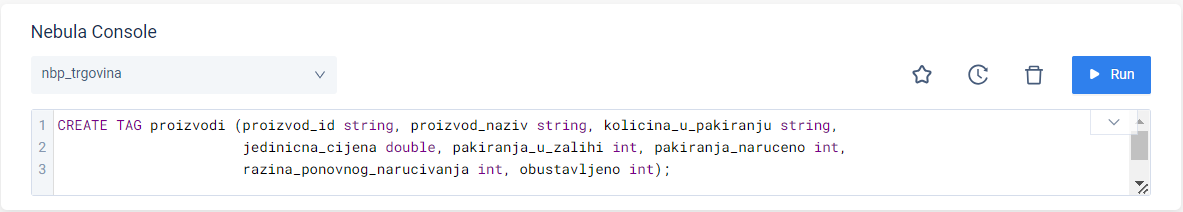

**Ubacivanje vrhova**
```
    INSERT VERTEX 
        <tag_ime_1 (<popis_atributa>),
            ...
        tag_ime_n (<popis_atributa>)>
    VALUES <id_vrha> :
        (<popis_vrijednosti_za_navedene_atribute>)
```

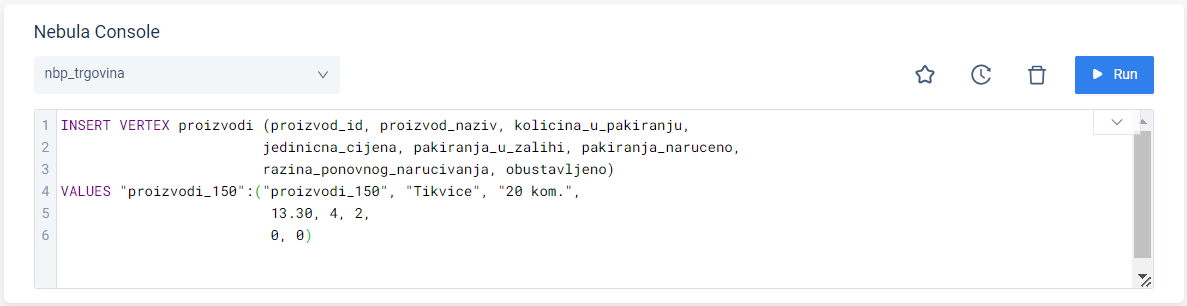

**Ubacivanje bridova**
```
    INSERT EDGE
        <tip_vrha> (<popis_atributa>)
    VALUES
        <id_izvornog_vrha> --> <id_odredišnog_vrha> : (<popis_vrijednosti_atributa),
            ...
        <id_izvornog_vrha> --> <id_odredišnog_vrha> : (<popis_vrijednosti_atributa)
```

**Pretraživanje podataka**

Predviđeni način pretraživanja grafa je pomoću sljedećeg uzorka:
```
    GO [<n> STEPS]
    FROM <lista_idjeva_vrhova>
    OVER <tipovi_vrhova>
    YIELD <lista_argumenata>
```
`<n> STEPS` je opcionalni argument. 


Postoje specijalne varijable koje se mogu koristiti unutar upita:
* `$$` : u svakom koraku prelaska preko bridova predstavlja *odredišni vrh*
* `$^` : isto kao prethodni primjer, ali *izvorni vrh*

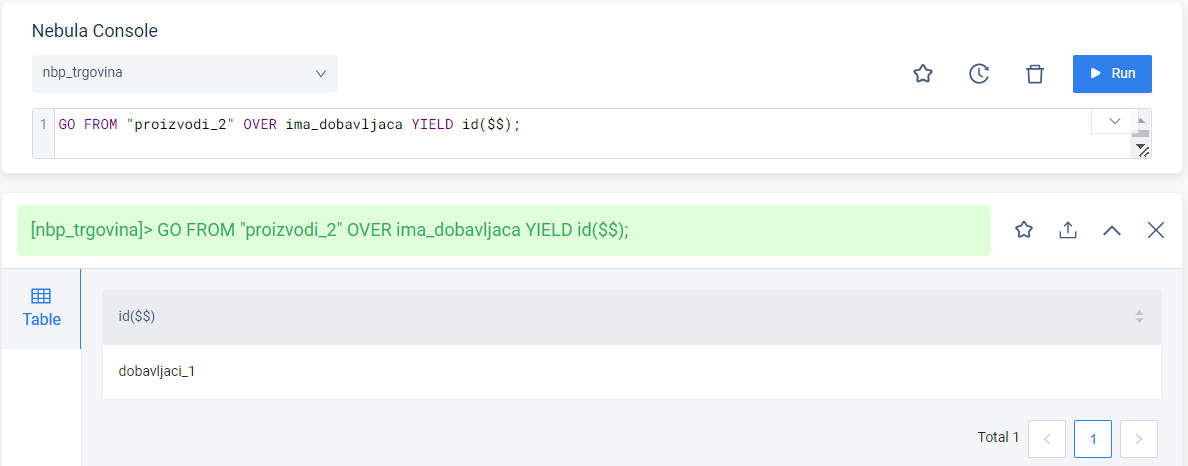

**Ulančavanje upita**
```
    ... YIELD ... as <ime_varijable> |
    ... $-.<ime_varijable> ...
```
Nakon jednog upita stavlja se simbol cjevovoda i u idućem upitu se može referencirati rezultat.
* `|` : simbol cjevovoda
* `$-` : predstavlja povratnu vrijednost prethodnog upita

Također je moguće koristiti privremene varijable prilikom slanja upita poslužitelju.
```
    $var = <upit>;
    ... $var.atribut ...;
```

**Analiza vrhova**

Ako želimo saznati detalje o nekom vrhu možemo postaviti upit o njegovim *properties* vrijednostima.
```
    FETCH PROP ON 
        <tag_ime_1>,
            ...
        <tag_ime_n>,
        <vrh_id_1>,
        ...
        <vrh_id_m>
    YIELD <povratni_parametri>
```

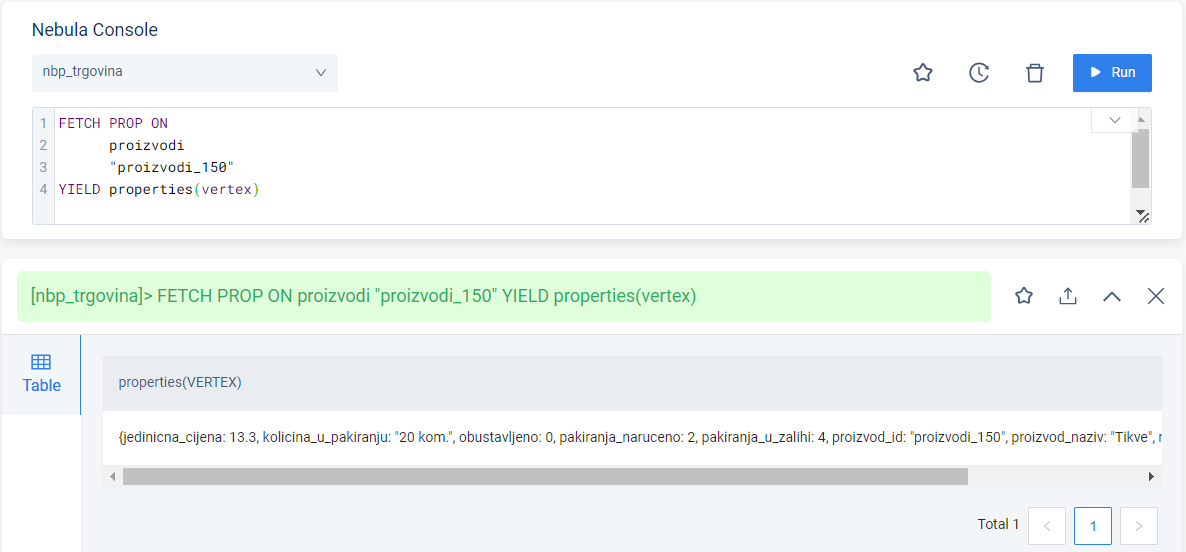

**Uvjetno pretraživanje**

Ako nas zanimaju vrhovi koji zadovoljavaju određene uvjete (`WHERE` part) koristimo `MATCH` i `LOOKUP` naredbe. U oba slučaja potrebno je koristiti *indekse*. Doduše, u verzijama nakon 3.0.0 `MATCH` funckonira i bez indeksa. Koristi se jednako kao u Cypheru. 

**Ažuriranje podataka**
```
    UPDATE VERTEX ON <tag_ime> <id_vrha>
    SET <tag_ime>.<atribut_ime> = <vrijednost>
```
```
    UPDATE EDGE <izvor_id_vrha> -> <odredište_id_vrha>
    OF <tip_brida>
    SET <tag_ime>.<atribut_ime> = <vrijednost>
```

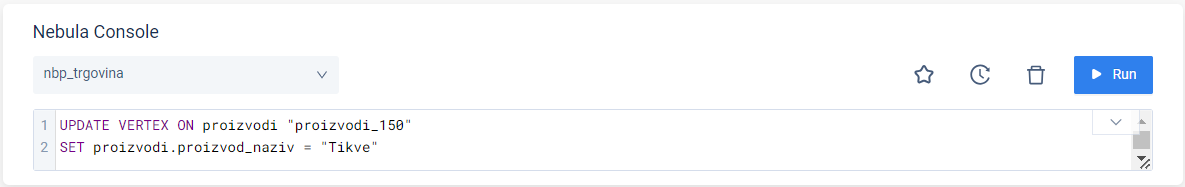

**Brisanje podataka**
```
    DELETE VERTEX <vrh_id_1>, ..., <vrh_id_n>
```
```
    DELETE EDGE <tip_brida> <id_vrha_izvora> -> <id_vrha_odredišta>, ...
```

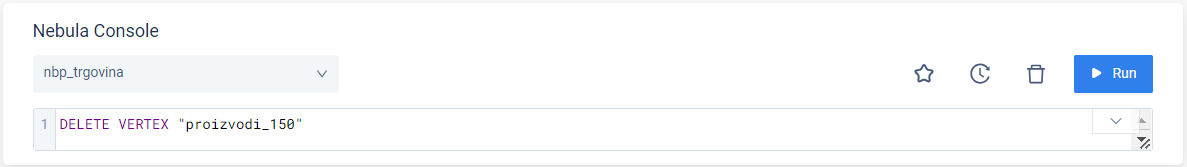

# Migracija baze "*nbp_trgovina*"

## Istraživanje opcija za uvoz podataka
Nakon što smo koristeći *Docker Desktop* i *NebulaGraph Docker Desktop Extension* napravili lokalnu bazu podataka, bilo je potrebno tu bazu popuniti podacima iz zadane baze ***nbp_trgovina***.

Prvi korak u migraciji baze nam je bio istražiti načine kako uvesti same podatke u Nebula Graph. Kako je Nebula Graph *open-source* i zbog svojih iznimnih perfomansi privlači mnoge nove korisnike, tako je za očekivati da postoje dostupne aplikacije koje pomažu u migraciji već postojećih baza podataka. Naišli smo na sljedeće:

* **Nebula Importer** <br>
Nebula Importer je zaseban alat za uvoz podataka u CSV formatu. Zahtijeva postavljeno *Golang* okruženje i postavljenu konfiguraciju *YAML* datoteke. Prednosti ovog alata su brzina i fleksibilnost u mogućnostima konfiguracije.
* **Nebula Exchange** <br>
Nebula Exchange je aplikacija za uvoz i izvoz podataka koja nudi mogućnost direktnog unosa posataka iz drugih tipova baza podataka. Zbog velikog broja podržanih formata uvoza, za korištenje Nebula Exchange potrebno je imati posebne konfiguracije i okruženja. Tako je potrebno imati instaliran operacijski sustav macOS ili CentOS 7, Java version 1.8, Maven, Apache Spark i konfigurirati navedene na posebne postavke. Neki od podržanih formata, odnosno tipova baza podatka za uvoz su: CSV, JSON, Neo4j, MySQL/PostgreSQL, Hive, ... 
* **Nebula Graph Studio** <br>
Nebula Graph Studio je web-preglednik alat za vizualizaciju, istraživanje i manipuliranje Nebula Graph bazom podataka. Nakon što je baza podataka kreirana na Docker-u, koristeći Nebula Graph Studio možemo pristupiti stranici za manipuliranje shemama, stranici s konzolom u kojoj možemo pisati i izvršavati upite nad bazom i stranici za uvoz podataka u CSV formatu.

Proučivši dostupne alate i aplikacije odlučili smo se za Nebula Graph Studio zbog najmanjih zahtjeva na operacijski sustav i instalirani softver. Format podataka koji je bilo potrebno koristiti za uvoz je CSV pa nam je idući korak bio dohvatiti podatke u CSV formatu.


## Izvoz podataka
Pristupili smo bazama podataka pod imenom ***nbp_trgovina*** (PostrgreSQL baza, Neo4j baza i MongoDB baza) kako bismo exportali podatke u obliku CSV datoteka.

* **Izvoz iz MongoDB** <br>
CSV datoteku iz MongoDB inačice baze podataka smo dohvatili koristeći alat *mongoexport*. Kako je MongoDB datotečna baza, problem je bio što podaci nisu razvrstani te je CSV datoteka sadržavala samo jedan stupac s podatcima u obliku dokumenta, iz čega je bilo teško razumjeti kako bismo napravili odgovarajuću grafovsku strukturu. 
* **Izvoz iz Neo4j** <br>
Logičan način razmišljanja nas je potakao da podatke pokušamo dohvatiti iz "slične" grafovske baze podataka Neo4j. U Neo4j browser alatu je dostupna direktna opcija preuzimanja CSV datoteke za izvršeni upit. Problem je nastao što su dohvaćeni podatci također bili u jednom stupcu i u key-value formatu. Iako su i Neo4j i Nebula Graph grafovske baze podataka, za razliku od Neo4j-a, Nebula Graph ima definiranu shemu vrhova i bridova, pa prije samog uvoza podataka potrebno je definirati shemu baze s *TAG*-ovima i *EDGE*-ovima. 
* **Izvoz iz PostreSQL** <br>
Treći pokušaj je bio dohvat podataka iz PostgreSQL inačice. U *DataGrip* okruženju je dostupna opcija izvoza baze u CSV formatu. Ovaj put je izvezena po jedna CSV datoteka za svaku tablicu iz relacijske baze. Svaki podatak je bio u svojoj ćeliji, a same CSV datoteke su bile direktna preslika tablica iz baze.

Posljednji korak je bio prilagodba podataka i uvoz u Nebula Graph.


## Prilagodba i uvoz podataka
Uvoz podataka smo obavili u tri faze:

* **Generiranje VID-ova** <br>
Za razliku od relacijskih baza koje razlikuju podatke prema primarnim ključevima na temelju jedne tablice, Nebula Graph razlikuje podatke na temelju cijelog Graph space-a, odnosno ako neki zaposlenik ima primarni ključ s vrijednošću "3" a neki proizvod ima također primarni ključ s vrijednošću "3", kod upita koji vraćaju vrh zaposlenika s primarnim ključem "3" imat ćemo također svojstva proizvoda s primarnim ključem "3". Velik broj tablica iz PostregeSQL inačice kao vrijednost id-a dodjeljuje upravo prirodne brojeve od 1 nadalje te se vrijednosti iz različitih tablica podudaraju. Iz tog razloga smo u CSV datotekama morali izmijeniti već postojeće vrijednosti primarnih ključeva na način da smo im kao prefix dodali "`naziv-tablice_`". Tako smo postigli jedinstvenost VID-ova u cijelom Graph space-u.
* **Stvaranje bridova** <br>
Relacijske baze veze implementiraju pomoću stranih ključeva ili zasebnih relacija. Grafovske baze veze implementiraju isključivo pomoću bridova (*EDGE*). Zbog toga smo morali umjetno stvoriti CSV-datoteke koje predstavljaju veze na način da imamo dva stupca koji predstavljaju VID-ove povezanih podataka te dodatne stupce za veze s dodatnim atributima. Preskočili smo baljvenje mogućnošću usmjerenja stvorenih veza jer je to pitanje dizajna koje nije utjecalo na našu zamišljenu aplikaciju. Slika prikazuje izmjene koje smo napravili na shemi baze:

<img src="shema.png" width="50%">
* **Povezivanje resursa** <br>
Naposljetku, preostalo je uvesti podatke u Nebula Graph Studio u našu predefiniranu bazu i povezati (*bind*) *TAG*-ove u shemi baze s stupcima iz CSV datoteka. Potom smo stvorili i ponovno izgradili indekse i baza je bila spremna za daljnju uporabu.


# Aplikacija


Uvoz bibliotelka za dizajn sučelja.

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, AppLayout, VBox, HBox
from IPython.display import clear_output

Instalacija paketa za rad s nebulom.

In [2]:
!pip install nebula3-python
from nebula3.gclient.net import ConnectionPool
from nebula3.Config import Config
from nebula3.data.DataObject import (
    ValueWrapper)
from IPython.display import clear_output

## Kod za sučelje *Unos_narudzbe*

Instalacija paketa:

In [ ]:
!pip install nebula3-python
from nebula3 import *

Automatizacija spajanja (može i bolje):

In [3]:
def povezi_se_i_obavi(upit):
    config = Config()
    config.max_connection_pool_size = 10
    connection_pool = ConnectionPool()

    ok = connection_pool.init([('127.0.0.1', 9669)], config)

    with connection_pool.session_context('root', 'root') as session:
        session.execute('USE nbp_trgovina')
        
        result = session.execute(upit)
        
        # convert ResultSet to dict
        columns = result.keys()
          
        d = {}
        for col_num in range(result.col_size()):
            col_name = columns[col_num]
            col_list = result.column_values(col_name)
            d[col_name] = [str(x)[1:-1] for x in col_list]

    
    connection_pool.close()
    return d

Primjer korištenja:

In [ ]:
def dohvati_dostavljace(prozor) :
    # ORDER BY koristi pipe, nakon kojeg referenciramo povratnu strukturu s $-.<property_name>
    upit = "LOOKUP ON dostavljaci YIELD properties(vertex).tvrtka_naziv AS naziv | ORDER BY $-.naziv"
    
    rezultat = povezi_se_i_obavi(upit)

    return rezultat

In [ ]:
dostavljaci = dohvati_dostavljace()["naziv"]

Ne funkcionira!? Javlja (nejasnu) grešku *Syntax error near INSERT*.
```
obradio = <prezime_zaposlenika>
ID = <id_narudzbe_koju_unosimo>
```

In [ ]:
upit = upit + f'''
                LOOKUP ON zaposlenici
                WHERE zaposlenici.prezime == "{obradio}"
                YIELD id(vertex) as id |
                INSERT EDGE obradio () VALUES "{ID}" -> $-.id : ();
            '''

Zaobilazak:

In [ ]:
    obradio_id = povezi_se_i_obavi(f'''
    
                LOOKUP ON zaposlenici
                WHERE zaposlenici.prezime == "{obradio}"
                YIELD id(vertex) as id;
                
            ''')["id"][0]
    
    upit = upit + f'''
                INSERT EDGE obradio () VALUES "{ID}" -> "{obradio_id}" : ();    
            '''

**Unos podataka**

Iduća funkcija će prilikom pritiska na gumb *Unesi* unijeti detalje u vrh pomoću taga *narudzbe* i povezati taj vrh s odgovarajućim vrhovima (*dobavljaci, zaposlenci, kupci, proizvodi*) u bazi ovisno o izabranim podacima.

In [4]:
def obradi_unos_narudzbe(gumb) : 
    
    
    narudzba = gumb.podaci  # dohvat podataka narudzbe prilikom klika na gumb
    
    '''# primjer koristenja gumba
    print("id: " + narudzba.detalji["id"].value)
    print("dostavljač: " + narudzba.detalji["dostavljac"].value)
    for proizvod in narudzba.kolicina :
        print(f"{proizvod} x {narudzba.kolicina[proizvod].value}, popust: {narudzba.popust[proizvod].value}")'''
        
    ID = narudzba.detalji["id"].value
    zaprimljeno = narudzba.detalji["zaprimljeno"].value
    rok = narudzba.detalji["rok"].value
    otprema = narudzba.detalji["otprema"].value
    tezina = narudzba.detalji["tezina"].value
    
    dostavljac = narudzba.detalji["dostavljac"].value
    obradio = narudzba.detalji["obradio"].value
    narucio = narudzba.detalji["narucio"].value
    
        
    upit = f'''
                INSERT VERTEX narudzbe 
                    (narudzba_id, datum_narudzbe,
                    rok_dostave, datum_otpreme, 
                    tezina)
                VALUES 
                    "{ID}" : ("{ID}","{zaprimljeno}","{rok}","{otprema}",{tezina});
                
            '''
        
    # povezivanje novonastale narudžbe s vrhom koji sadrži informacije o izabranom zaposleniku
    
    obradio_id = povezi_se_i_obavi(f'''
                LOOKUP ON zaposlenici
                WHERE zaposlenici.prezime == "{obradio}"
                YIELD id(vertex) as id;
            ''')["id"][0]
    
    
    
    upit = upit + f'''
                INSERT EDGE obradio () VALUES "{ID}" -> "{obradio_id}" : ();
                
                '''
    
    # analogno za kupce
    
    narucio_id = povezi_se_i_obavi(f'''
                LOOKUP ON kupci 
                WHERE kupci.tvrtka_naziv == "{narucio}"
                YIELD id(vertex) as id;
            ''')["id"][0]
    
    upit = upit + f'''
                INSERT EDGE narucio () VALUES "{ID}" -> "{narucio_id}" : ();
                
                '''
    
    # isto za dostavljace
    
    dostavljac_id = povezi_se_i_obavi(f'''
                LOOKUP ON dostavljaci 
                WHERE dostavljaci.tvrtka_naziv == "{dostavljac}"
                YIELD id(vertex) as id;
            ''')["id"][0]
    
    upit = upit + f'''
                INSERT EDGE dostavio () VALUES "{ID}" -> "{dostavljac_id}" : ();
                
                '''
    
    # protrčimo po svim proizvodima čija količina > nula i spojimo ovu narudzbu s vrhovima tih proizvoda
    for proizvod in narudzba.kolicina :
        
        kolicina = narudzba.kolicina[proizvod].value
        popust = narudzba.popust[proizvod].value
        
        if kolicina > 0 :
            
            proizvod_id = povezi_se_i_obavi(f'''
                LOOKUP ON proizvodi 
                WHERE proizvodi.proizvod_naziv == "{proizvod}"
                YIELD id(vertex) as id;
            ''')["id"][0]
            
            upit = upit + f'''
                INSERT EDGE sadrzi (kolicina, popust) 
                VALUES "{ID}" -> "{proizvod_id}" : ({kolicina}, {popust});
                
                '''
    print("generiran je upit:")
    print("")
    print(upit)
    
    povezi_se_i_obavi(upit)

**Dohvat podataka**

Sučelje se dinamički popunjava kontaktiranjem baze i dohvatom podataka koji se pojavljuju u padajućim izbornicima kod unosa podataka o narudžbama. Na primjer, za kupca narudžbe se može odabrati samo ime nekog kupca iz baze podataka. Isto za zaposlenike u dostavljače.

In [5]:
def dohvati_dostavljace(prozor) :
    # ORDER BY koristi pipe, nakon kojeg referenciramo povratnu strukturu s $-.<property_name>
    upit = "LOOKUP ON dostavljaci YIELD properties(vertex).tvrtka_naziv AS naziv | ORDER BY $-.naziv"
    
    rezultat = povezi_se_i_obavi(upit)

    return rezultat

def dohvati_kupce(prozor) :
    upit = "LOOKUP ON kupci YIELD properties(vertex).tvrtka_naziv AS naziv | ORDER BY $-.naziv"
    
    rezultat = povezi_se_i_obavi(upit)
    
    return rezultat

def dohvati_zaposlenike(prozor) :
    upit = "LOOKUP ON zaposlenici YIELD properties(vertex).prezime AS prez | ORDER BY $-.prez"
    
    rezultat = povezi_se_i_obavi(upit)
    
    return rezultat

def dohvati_proizvode(prozor) :
    # provjeri upit !!!
    upit = "LOOKUP ON proizvodi YIELD properties(vertex).proizvod_naziv AS naz | ORDER BY $-.naz"

    rezultat = povezi_se_i_obavi(upit)
    
    return rezultat

U ovom bloku kreirana je klasa koja reprezentira prozor sučelja za unos podataka o *narudžbi*. Pozivom `.draw()` na instanci klase prikazuje se interface. 

DOKUMENTACIJA :

* kod crtanja dijela sučelja se dohvaćaju proizvodi iz baze i ispisuju se kontrole za *količinu i popust* koja ulazi u narudžbu
```
this.detalji[<vrsta_podatka>].value == unos korisnika u kućicu <vrsta_podatka>, npr. "rok"
this.kolicina[<ime_proizvoda>].value == kolicina tog proizvoda
this.popust[<ime_proizvoda>].value == odabrani popust za taj proizvod
```
* iteriranje po svim proizvodima na sučelju:
```
for key in this.kolicina :
    ... key == <naziv_proizvoda> ...
```

In [6]:
# definira širinu stupaca u tablici s količinama
LAYOUT = {"width" : "80px"}

LAYOUT_WIDE = {"width" : "150px",
               "text-align" : "center"}

SCROLL_LAYOUT = {"overflow_y" : "auto",
                 "display" : "block",
                 "height" : "350px",
                 "border" : "1px solid black",
                 "padding" : "10px"}

class Unos_narudzba :

    def __init__(this) :

        # inicijalizacija map-ova;
        this.kolicina = {}  
        this.popust = {}    
        this.detalji = {}  

        # tekstualni detalji : statični
        this.detalji["id"] = widgets.Text(description="id:")   # komplicirano je automatizirati unos pa je ostavljeno za ručno
        this.detalji["zaprimljeno"] = widgets.DatePicker(description="Zaprimljeno:")
        this.detalji["rok"] = widgets.DatePicker(description="Rok:")
        this.detalji["otprema"] = widgets.DatePicker(description="Otprema:")
        this.detalji["tezina"]= widgets.BoundedIntText(description="Težina(kg):") # provjeri mjernu jedinicu

        # edge related detalji koji se biraju iz postojećih podataka pomoću padajućih
        # izbornika i checkboxova;
        this.detalji["obradio"] = widgets.Dropdown(description="Obradio:")
        this.detalji["narucio"] = widgets.Dropdown(description="Naručio:",)
        this.detalji["dostavljac"] = widgets.Dropdown(description="Dostavljač:")


    # crta GUI
    def draw(this) :
              
        # primjer dinamičkog popunjavanja; 
        # treba sadržavati sve dostavljače iz baze
        
        this.detalji["dostavljac"].options = this.dohvati_dostavljace()["naziv"] 
        this.detalji["narucio"].options = this.dohvati_kupce()["naziv"]
        this.detalji["obradio"].options = this.dohvati_zaposlenike()["prez"]

        proizvodi = this.dohvati_proizvode()["naz"]

        # kreiranje layouta ipywidgeta

        this.kolicina = {proizvod : widgets.BoundedIntText(
            value = 0,
            layout = LAYOUT,    # širina
            min = 0
        ) for proizvod in proizvodi}

        this.popust = {proizvod : widgets.BoundedFloatText(
            min=0, 
            max=1, 
            step=0.01, 
            value=0, 
            layout = LAYOUT) for proizvod in proizvodi}

        lijeva = widgets.VBox([this.detalji[key] for key in this.detalji],
                              layout={"padding" : "10px"})

        desna = widgets.VBox([      

            # lista redaka s kontrolama količine i popusta
            widgets.HBox([
                # lista elemenata svakog retka
                widgets.Label(proizvod_naziv, layout=LAYOUT_WIDE),
                this.kolicina[proizvod_naziv],
                this.popust[proizvod_naziv]
            ])
        for proizvod_naziv in proizvodi], layout = SCROLL_LAYOUT)

        desna = widgets.VBox([
            # opis stupaca
            widgets.HBox([
                widgets.Label("Proizvod", layout=LAYOUT_WIDE),
                widgets.Label("Kolicina", layout=LAYOUT),
                widgets.Label("Popust", layout=LAYOUT)
            ]),
            desna])

        razmak = widgets.VBox([], layout={"width" : "50px"})
        box = widgets.HBox([lijeva, razmak, desna])
        display(box)

        # davanje funckionalnosti gumbu

        gumb = widgets.Button(description="Unesi", style={"button_color" : "red"})
        gumb.podaci = this
        gumb.on_click(obradi_unos_narudzbe)
        display(gumb)

Unos_narudzba.dohvati_dostavljace = dohvati_dostavljace
Unos_narudzba.dohvati_kupce = dohvati_kupce
Unos_narudzba.dohvati_zaposlenike = dohvati_zaposlenike
Unos_narudzba.dohvati_proizvode = dohvati_proizvode

## Prozor *Unos_narudzbe*

In [7]:
unos = Unos_narudzba()
unos.draw()

Button(description='Unesi', style=ButtonStyle(button_color='red'))

## Primjer *Unos_narudzbe*

Stanje prozora prije unosa u bazu:

![prozor](prozor.png)

Generirani upit:

![upit](gen_upit.png)

Stanje baze nakon unosa narudzbe:

![graf](graf.png)

## Kod za sučelje *Update_kupca*

Slično kao kod funkcije *Unos_narudzbe* grafičko sučelje je definirano pomoću *ipywidgets* modula. Ono se sastoji od elemenata za unos vrijednosti atributa za vrhove s tag-om *kupci*.

Kod sučelja se sastoji od dvije funkcije i jedne klase:

* **Funkcija `povezi_se_i_obavi_upit(upit, provjeri_kupac_id)`** <br>
Postavlja konfiguraciju i pomoću connection_pool-a se povezuje na bazu podataka na port-u 9669. Ima dvije funkcionalnosti koje alternira na temelju parametra `provjeri_kupac_id`. Prva funkcionalnost je provjera postoji li upisani ID kupca u bazi, a druga je izvršavanje upita, odnosno stringa koji predstavlja update naredbu.

* **Klasa `Update_kupac`** <br>
Pri inicijalizaciji mapira tekstualne widget-e a pozivom metode `draw()` iscrtava tekstualne widgete i postavlja gumb za potvrdu unosa.

* **Funkcija `obradi_update_kupca(gumb)`** <br>
Dohvaća promjene kupčevih podataka unesene u tekstualne okvire i na temelju unesenih novih podataka stvara string, `string_s_update_naredbom`, koji sadrži nGQL naredbu za update. Prije samog update-a poziva se funkcija `povezi_se_i_obavi_upit` kako bi se provjerilo postoji li uopće kupac s unesenim id-jem.

In [9]:
def povezi_se_i_obavi_upit(upit, provjeri_kupac_id):
    config = Config()
    config.max_connection_pool_size = 10
    connection_pool = ConnectionPool()

    ok = connection_pool.init([('127.0.0.1', 9669)], config)

    with connection_pool.session_context('root', 'root') as session:
        session.execute('USE nbp_trgovina')
        
        # provjeri je li postoji kupac s unesenim id-jem
        if(provjeri_kupac_id == 1): 
          result = session.execute(upit)

          # convert ResultSet to dict
          columns = result.keys()
          
          d = {}
          for col_num in range(result.col_size()):
              col_name = columns[col_num]
              col_list = result.column_values(col_name)
              d[col_name] = [x for x in col_list]

          L = d["COUNT(k)"]
          
          if(L[0].as_int() != 1):
              connection_pool.close()
              return 0
        else:
          result = session.execute(upit)

    # close the pool
    connection_pool.close()
    return 1

class Update_kupca :

    def __init__(this) :

        # inicijalizacija map-ova;  
        this.detalji = {}  

        # tekstualni detalji : statični
        this.detalji["kupac_id"] = widgets.Text(description="ID kupca:") 
        this.detalji["tvrtka_naziv"] = widgets.Text(description="Naziv tvrtke")
        this.detalji["kontakt_ime"] = widgets.Text(description="Kontakt ime:")
        this.detalji["kontakt_titula"] = widgets.Text(description="Kontakt titula:")
        this.detalji["adresa"] = widgets.Text(description="Adresa:")
        this.detalji["grad"] = widgets.Text(description="Grad:")
        this.detalji["regija"] = widgets.Text(description="Regija:")
        this.detalji["postanska_oznaka"] = widgets.Text(description="Poštanska oznaka:")
        this.detalji["drzava"] = widgets.Text(description="Država:")
        this.detalji["telefon"] = widgets.Text(description="Telefon:")
        this.detalji["fax"] = widgets.Text(description="Fax:")


    # crta GUI
    def draw(this) :
        print("Unesite ID kupca i popunite one podatke koje je potrebno ažurirati. \nNakon toga pritisnite gumb Ažuriraj na ispod podataka.")
        lijeva = widgets.VBox([this.detalji[key] for key in this.detalji])

        box = widgets.HBox([lijeva])
        display(box)

        gumb = widgets.Button(description="Ažuriraj", style={"button_color" : "red"})
        gumb.podaci = this
        gumb.on_click(obradi_update_kupca)
        display(gumb)

def obradi_update_kupca(gumb) : 
    
    string_s_update_naredbom = "UPDATE VERTEX ON kupci \""
    kupac = gumb.podaci
    string_s_update_naredbom = string_s_update_naredbom + kupac.detalji["kupac_id"].value + "\" SET " 
    
    if(len(kupac.detalji["tvrtka_naziv"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "tvrtka_naziv = \"" + kupac.detalji["tvrtka_naziv"].value + "\", "
    if(len(kupac.detalji["kontakt_ime"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "kontakt_ime = \"" + kupac.detalji["kontakt_ime"].value + "\", "
    if(len(kupac.detalji["kontakt_titula"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "kontakt_titula = \"" + kupac.detalji["kontakt_titula"].value + "\", "
    if(len(kupac.detalji["adresa"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "adresa = \"" + kupac.detalji["adresa"].value + "\", "
    if(len(kupac.detalji["grad"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "grad = \"" + kupac.detalji["grad"].value + "\", "
    if(len(kupac.detalji["regija"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "regija = \"" + kupac.detalji["regija"].value + "\", "
    if(len(kupac.detalji["postanska_oznaka"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "postanska_oznaka = \"" + kupac.detalji["postanska_oznaka"].value + "\", "
    if(len(kupac.detalji["drzava"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "drzava = \"" + kupac.detalji["drzava"].value + "\", "
    if(len(kupac.detalji["telefon"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "telefon = \"" + kupac.detalji["telefon"].value + "\", "
    if(len(kupac.detalji["fax"].value)>0): string_s_update_naredbom = string_s_update_naredbom + "fax = \"" + kupac.detalji["fax"].value + "\", "

    upit = string_s_update_naredbom[:-2]
  
    provjera = "MATCH (k:kupci{kupac_id:\"" + kupac.detalji["kupac_id"].value + "\"}) RETURN COUNT(k)"
    
    if (povezi_se_i_obavi_upit(provjera, 1) == 0):
        clear_output()
        print("NAVEDENI ID KUPCA NE POSTOJI, popravite unos.\n\n")
        update.draw()
    else: 
        povezi_se_i_obavi_upit(upit, 0)
    


## Prozor *Update_kupca*

In [10]:
update = Update_kupca()
update.draw()

Unesite ID kupca i popunite one podatke koje je potrebno ažurirati. 
Nakon toga pritisnite gumb Ažuriraj na ispod podataka.


Button(description='Ažuriraj', style=ButtonStyle(button_color='red'))

## Primjer update-a kupca



 * Prva slika prikazuje **zahtjev za promjenom naziva tvrtke** kupca s id-jem *kupci_ANATR* iz aplikacije.

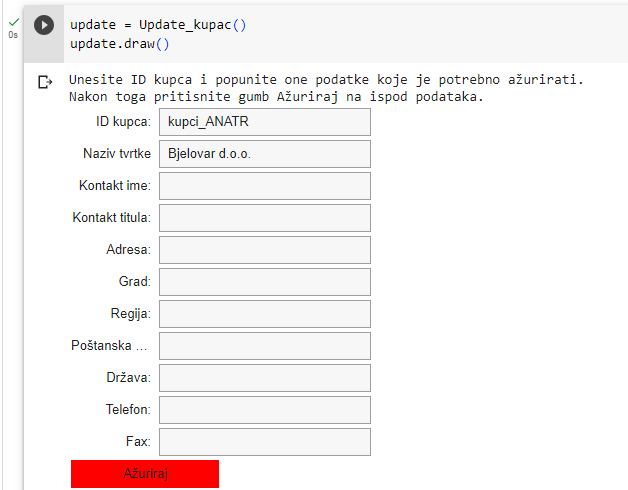

* Druga slika prikazuje **provjeru promijenjenog naziva tvrtke u bazi** kroz Nebula Graph Studio

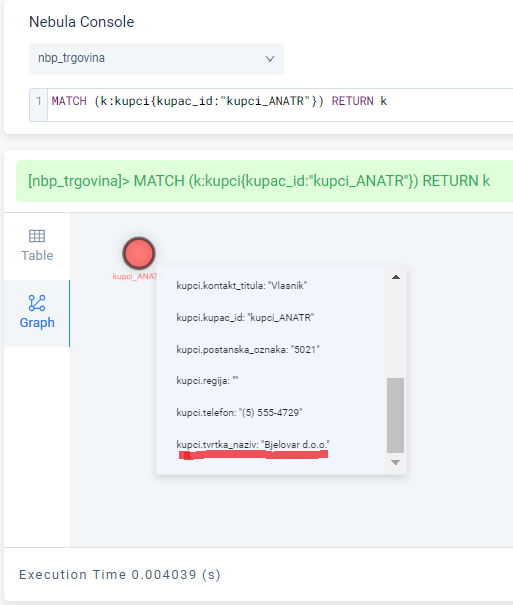

# Zaključak

Premda se Nebula Graph na prvi pogled izgleda kao da je isključivo grafovska baza podataka, upoznavanjem s njenom specifičnom arhitekturom smo imali priliku vidjeti kako implementacija koristi i pogodne elemente dokumentskih baza na nižoj razini. Također za razliku od Neo4j baze, Nebula Graph ima definiranu shemu i jedinstvene vid-jeve za svaki objekt na temelju cijele baze.

Proučili smo, objasnili i demonstrirali osnovne naredbe nGQL-a, jezika specifično napravljenog za manipulaciju Nebula Graph bazama. 

Izvezli smo bazu podataka nbp_trgovina iz PostgreSQL-a, prilagodili strukturu i uvezli u Nebula Graph bazu koju smo lokalno pokrenuli pomoću Docker-a.

Na kraju smo demonstrirali pristup Nebula Graph bazi podataka iz jupyter bilježnice napravivši aplikaciju s dva prozora koja omogućuju unošenje novih narudžbi i mijenjanje podataka o kupcima.

# Literatura



* https://docs.nebula-graph.io/3.5.0/ <br>
* https://www.youtube.com/watch?v=wqpLofw_dDE&ab_channel=NebulaGraphDB <br>
* https://pkg.go.dev/github.com/vesoft-inc/nebula-go/v3#section-readme <br>